# Importing Packages
Here, we import the relevant packages and libraries as needed

In [70]:
import keras
keras.__version__

'2.15.0'

In [71]:
# Built-in Imports
import random

In [72]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [73]:
# Keras Imports
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import get_file, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset Downloader
This section will download the selected [MedMNIST](https://medmnist.github.io/) dataset as a NumPy array object to your Google Colab instance.

This code was directly adapted from Jacob Carse's notebook, as provided in the assignment notebook.

In [74]:
DATA_NAME = "PneumoniaMNIST"

In [75]:
!wget https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
from info import INFO
data = INFO[DATA_NAME.lower()]

--2024-03-28 21:21:13--  https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27766 (27K) [text/plain]
Saving to: ‘info.py.1’

info.py.1           100%[===================>]  27.12K  --.-KB/s    in 0.004s  

2024-03-28 21:21:13 (6.53 MB/s) - ‘info.py.1’ saved [27766/27766]



In [76]:
# Downloads the dataset file hosted on Zenodo.
file_path = get_file(fname="dataset.npz",
                     origin=data["url"],
                     md5_hash=data["MD5"])

In [77]:
# Loads the downloaded NumPy object.
dataset = np.load(file_path)

# Gets the training images and labels from the NumPy object.
train_x = dataset["train_images"]
train_y = dataset["train_labels"]

# Gets the validation images and labels from the NumPy object.
val_x = dataset["val_images"]
val_y = dataset["val_labels"]

# Gets the testing images and labels from the NumPy object.
test_x = dataset["test_images"]
test_y = dataset["test_labels"]



## Data Exploration
In this section we have a look at our data, their distributions to see if it is ready to be used within our machine learning algorithm.

In [78]:
# Declares a list of labels.
labels = list(data["label"].values()) + ["total"]

# Gets the counts for each label in each of our datasets.
_, train_counts = np.unique(train_y, return_counts=True)
_, val_counts = np.unique(val_y, return_counts=True)
_, test_counts = np.unique(test_y, return_counts=True)

# Prints the counts for each label from each dataset.
print(pd.DataFrame(list(zip(np.append(train_counts, [sum(train_counts)]),
                            np.append(val_counts, [sum(val_counts)]),
                            np.append(test_counts, [sum(test_counts)]))),
                   index=labels, columns=["Train", "Val", "Test"]))

           Train  Val  Test
normal      1214  135   234
pneumonia   3494  389   390
total       4708  524   624


2318: pneumonia
Minimum pixel value: 5, Maximum pixel value: 187


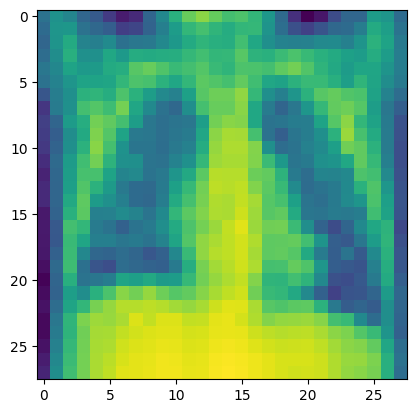

In [79]:
# Displays a random image from training dataset.
index = random.randint(0, len(train_x))
print(f"{index}: {labels[train_y[index][0]]}")
plt.imshow(train_x[random.randint(0, len(train_x))])

image = train_x[index]
min_pixel_value = np.min(image)
max_pixel_value = np.max(image)
print(f"Minimum pixel value: {min_pixel_value}, Maximum pixel value: {max_pixel_value}")

We can see from above that the train images array does not include the channel dimension. We include it below to avoid errors later.

The images are 28*28, grayscale.
We'll rescale both the training images and the testing images from [0,255] to [0,1] to be better used by the neural network.

In [80]:
#Check the array of the input data
print("Initial shape of train_x array:", train_x.shape)

# Reshape the image arrays to include the channel dimension
train_x = np.expand_dims(train_x, axis=-1)
val_x = np.expand_dims(val_x, axis=-1)
test_x = np.expand_dims(test_x, axis=-1)


Initial shape of train_x array: (4708, 28, 28)


# Model - Basic Convnet
This convnet was directly replicated from the provided notebook.
The code was simplified slightly to be similar to the code shown in the labs due to my own inexperience with Python and Keras.

In [81]:
from keras import layers
from keras import models

model_1 = models.Sequential()
model_1.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_1.add(keras.layers.MaxPooling2D((2, 2)))

model_1.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model_1.add(keras.layers.MaxPooling2D((2, 2)))

model_1.add(layers.Flatten())
model_1.add(layers.Dense(1, activation='sigmoid'))

model_1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 5, 5, 32)          0         
 ng2D)                                                           
                                                                 
 flatten_9 (Flatten)         (None, 800)               0         
                                                                 
 dense_16 (Dense)            (None, 1)                

In [82]:
model_1.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [83]:
history_1 = model_1.fit(train_x, train_y, batch_size = 64,
                    validation_data=(val_x, val_y),
                    epochs= 50)

Epoch 1/50
74/74 [==============================] - 4s 38ms/step - loss: 2.1312 - accuracy: 0.8297 - val_loss: 0.3189 - val_accuracy: 0.8454
Epoch 2/50
74/74 [==============================] - 3s 39ms/step - loss: 0.2637 - accuracy: 0.8923 - val_loss: 0.2635 - val_accuracy: 0.9046
Epoch 3/50
74/74 [==============================] - 3s 34ms/step - loss: 0.2239 - accuracy: 0.9110 - val_loss: 0.2211 - val_accuracy: 0.9103
Epoch 4/50
74/74 [==============================] - 3s 39ms/step - loss: 0.2020 - accuracy: 0.9197 - val_loss: 0.2043 - val_accuracy: 0.9218
Epoch 5/50
74/74 [==============================] - 3s 45ms/step - loss: 0.1923 - accuracy: 0.9212 - val_loss: 0.2160 - val_accuracy: 0.9065
Epoch 6/50
74/74 [==============================] - 3s 40ms/step - loss: 0.1775 - accuracy: 0.9282 - val_loss: 0.2322 - val_accuracy: 0.8989
Epoch 7/50
74/74 [==============================] - 2s 33ms/step - loss: 0.1720 - accuracy: 0.9295 - val_loss: 0.1719 - val_accuracy: 0.9351
Epoch 8/50
74

In [84]:
test_loss, test_accuracy = model_1.evaluate(test_x, test_y)

20/20 [==============================] - 0s 7ms/step - loss: 0.5391 - accuracy: 0.8349


In [85]:
history_dict = history_1.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

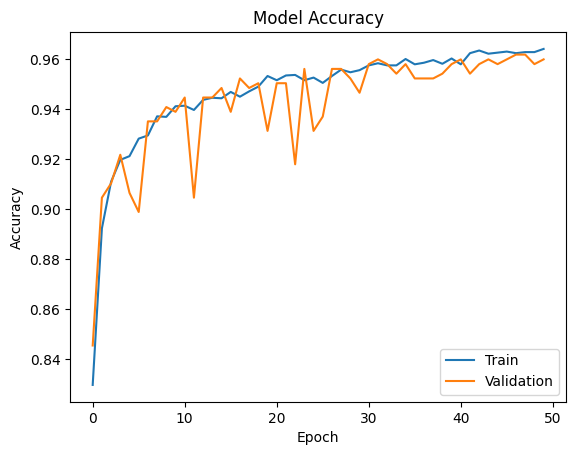

In [86]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

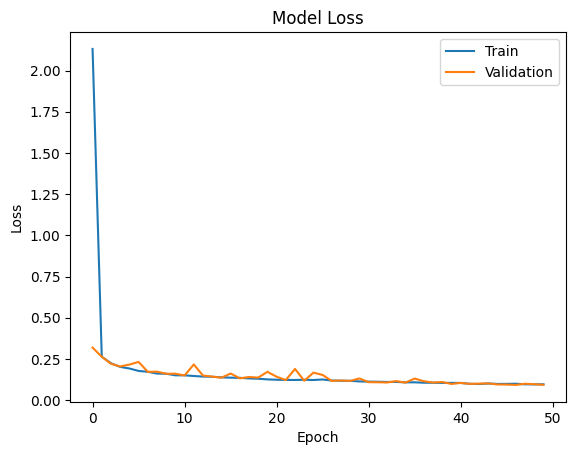

In [87]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Here, we see that the training accuracy and the model accuracy both improve with successive epochs, and consequently, the loss reduces.

However, there are anomalous spikes starting around the 4 epoch mark,

This could very well be due to a couple factors:
1. The training data has not been rescaled, and the neural network is processing the grayscale pixel values of between [0,255]
2. There is simply not enough samples in the validation dataset.
3. Model could be getting trapped in a local minima and with further iteration for more epochs, we would continue to see a gradual decline.

However, that being said, the network model performs decently well. Loss decreases with each successive epoch, while the overall validation accurracy increases.

Our test accuracy is around 84%

# Model  Dense Layers

  All Conv2D layers have been replaced with Dense layers instead.
  The input shape has been flattened before it is passed into the Dense layers.

In [88]:
from keras import layers
from keras import models

model_2 = keras.Sequential()
model_2.add(layers.Flatten(input_shape=(28, 28, 1)))
model_2.add(keras.layers.Dense(16, activation='relu'))
model_2.add(keras.layers.Dense(16, activation='relu'))


model_2.add(keras.layers.Dense(1, activation='sigmoid'))

model_2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 784)               0         
                                                                 
 dense_17 (Dense)            (None, 16)                12560     
                                                                 
 dense_18 (Dense)            (None, 16)                272       
                                                                 
 dense_19 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12849 (50.19 KB)
Trainable params: 12849 (50.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [89]:
model_2.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [90]:
# We use the data generator to pass the training and validation data to the model to train it.
history_2 = model_2.fit(train_x, train_y, batch_size=64,
                    validation_data = (val_x, val_y),
                    epochs= 50)

Epoch 1/50
74/74 [==============================] - 1s 7ms/step - loss: 5.0596 - accuracy: 0.7362 - val_loss: 0.6874 - val_accuracy: 0.7424
Epoch 2/50
74/74 [==============================] - 0s 4ms/step - loss: 0.6845 - accuracy: 0.7421 - val_loss: 0.6817 - val_accuracy: 0.7424
Epoch 3/50
74/74 [==============================] - 0s 4ms/step - loss: 0.6790 - accuracy: 0.7421 - val_loss: 0.6764 - val_accuracy: 0.7424
Epoch 4/50
74/74 [==============================] - 0s 4ms/step - loss: 0.6738 - accuracy: 0.7421 - val_loss: 0.6713 - val_accuracy: 0.7424
Epoch 5/50
74/74 [==============================] - 0s 4ms/step - loss: 0.6688 - accuracy: 0.7421 - val_loss: 0.6665 - val_accuracy: 0.7424
Epoch 6/50
74/74 [==============================] - 0s 3ms/step - loss: 0.6641 - accuracy: 0.7421 - val_loss: 0.6619 - val_accuracy: 0.7424
Epoch 7/50
74/74 [==============================] - 0s 3ms/step - loss: 0.6596 - accuracy: 0.7421 - val_loss: 0.6575 - val_accuracy: 0.7424
Epoch 8/50
74/74 [==

In [91]:
test_loss, test_accuracy = model_2.evaluate(test_x, test_y)

20/20 [==============================] - 0s 2ms/step - loss: 0.6674 - accuracy: 0.6250


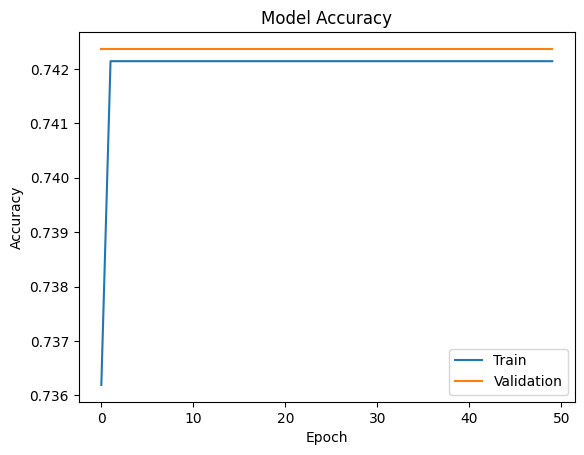

In [92]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

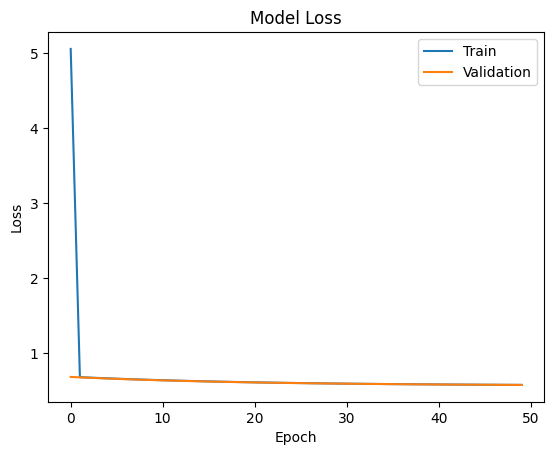

In [93]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Immediately, we see a glaring issue from out plots. Our model plots seem to line up very close to one another, but the test accuracy is 62%.

This is a clear indication that the model, without any convnet layers is overfitting and therefore does not work well with actual data.

# Model - Deep Network Design

## Data Augmentation
Here, we define a new data augmentation fucntion to be used in our deep network design.
We rescale the image pixels from the range [0,255] into the range [0,1] to be better used by the network.

We augment the training data to give the model more images to process, so that we can raise the model's accuracy and prevent overfitting due to too little samples.

The validation data has not been augmented!

In [94]:
train_datagen = ImageDataGenerator(rotation_range =40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.1,
                                   rescale=1./255
                                   )

test_datagen = ImageDataGenerator (rescale=1./255
                                  )

train_generator = train_datagen.flow(train_x, train_y, batch_size=64)

validation_generator = test_datagen.flow(val_x, val_y, batch_size=64)

We define the model structure as seen below.
The depth of the model, and number of filters, were repeatedly tested to find a common ground to give suitable results.

Since the images are small (28*28), we need to be careful to not overreduce the image shape.

We attempted to minimise overfitting by resizing the network, including a dropout layer and adding regularization to penalise large weights. Batch normalisation was attempted, but did not seem to help.

The model is more complex compared to the ones above, and therefore takes longer to train, especially when Colab's GPU's are unavailable.

In [349]:
from keras import layers
from keras import models
from keras import regularizers

model_3 = keras.Sequential()
model_3.add(keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape= (28, 28, 1)))
model_3.add(keras.layers.MaxPooling2D((2, 2)))
model_3.add(keras.layers.Conv2D(16, (3, 3), activation='relu'))
model_3.add(keras.layers.MaxPooling2D((2, 2)))
model_3.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model_3.add(keras.layers.MaxPooling2D((2, 2)))


model_3.add(keras.layers.Flatten())
model_3.add(keras.layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model_3.add(keras.layers.Dropout(0.3))        #add a dropout to mitigate overfitting
model_3.add(keras.layers.Dense(1, activation='sigmoid'))

model_3.summary()

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_168 (Conv2D)         (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_134 (MaxPool  (None, 13, 13, 16)        0         
 ing2D)                                                          
                                                                 
 conv2d_169 (Conv2D)         (None, 11, 11, 16)        2320      
                                                                 
 max_pooling2d_135 (MaxPool  (None, 5, 5, 16)          0         
 ing2D)                                                          
                                                                 
 conv2d_170 (Conv2D)         (None, 3, 3, 32)          4640      
                                                                 
 max_pooling2d_136 (MaxPool  (None, 1, 1, 32)        

In [350]:
from keras import optimizers

model_3.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['acc'])

In [351]:
history_deep = model_3.fit(train_generator, validation_data=(validation_generator), epochs=50)

Epoch 1/50
74/74 [==============================] - 5s 47ms/step - loss: 0.6059 - acc: 0.7421 - val_loss: 0.5586 - val_acc: 0.7424
Epoch 2/50
74/74 [==============================] - 4s 51ms/step - loss: 0.4949 - acc: 0.7636 - val_loss: 0.3761 - val_acc: 0.8397
Epoch 3/50
74/74 [==============================] - 3s 44ms/step - loss: 0.4026 - acc: 0.8195 - val_loss: 0.3443 - val_acc: 0.8435
Epoch 4/50
74/74 [==============================] - 3s 41ms/step - loss: 0.3486 - acc: 0.8424 - val_loss: 0.2916 - val_acc: 0.8588
Epoch 5/50
74/74 [==============================] - 4s 58ms/step - loss: 0.3267 - acc: 0.8615 - val_loss: 0.2740 - val_acc: 0.8760
Epoch 6/50
74/74 [==============================] - 3s 44ms/step - loss: 0.3093 - acc: 0.8723 - val_loss: 0.4284 - val_acc: 0.7996
Epoch 7/50
74/74 [==============================] - 3s 42ms/step - loss: 0.3070 - acc: 0.8685 - val_loss: 0.2666 - val_acc: 0.8931
Epoch 8/50
74/74 [==============================] - 3s 42ms/step - loss: 0.3156 - a

In [344]:
history_dict = history_deep.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

## Plot Learning Curves
This is where we visualise the training of the model.

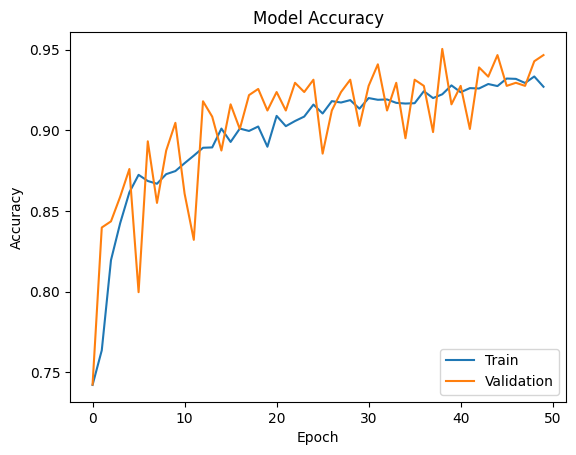

In [352]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history_deep.history['acc'])
plt.plot(history_deep.history['val_acc'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

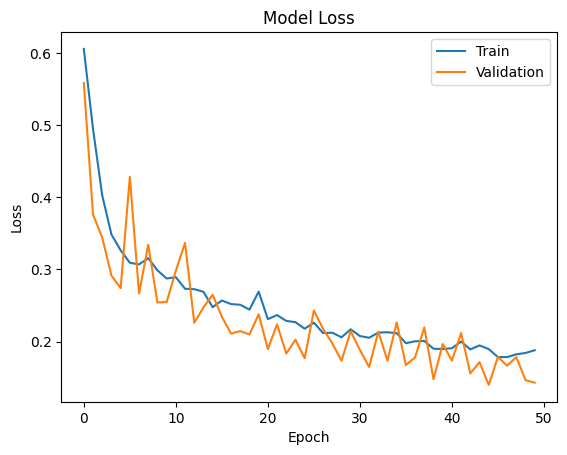

In [353]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history_deep.history['loss'])
plt.plot(history_deep.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [354]:
test_loss, test_accuracy = model_3.evaluate(test_x, test_y)

20/20 [==============================] - 0s 5ms/step - loss: 32.0582 - acc: 0.8654


Here, we'll evaluate the model on the test data.
Our current model, trained over 50 epochs, ended up with an accuracy around 93%,but our test accuracy comes out at around 86%.
This is a sign that our model has overfit the training data.

The validation data is extremely spiky as well, which is unavoidable when dealing with any form of Stochastic Gradient Descent operator, like Adam.
We could improve this by using a larger batch size, but that now has implications for the number of steps per epoch. We can also get trapped in a local minima, leading to our model getting stuck.

## Learnings
I've attempted to optimise the network design by finding an optimal width and depth based around the inputs, the output accuracies and performance of the model on Colab's system. I was limited by the fact that Colab often disconnects us from GPU usage, meaning a more complex model with more parameters would take insanely long to iterate on.

Looking at our results, we see that as the model trains, the losses of both the training and validation data decrease and the accuracy of the model increases.
From the trends, we can infer that the model may converge after enough iterations, but can definitely be improved.

Further improvements could be made by experimenting on the hyperparameters, such as the regularization weights, learning rates and batch steps per epoch. With the proper hardware, I'd recommend evaluating by incoporating a pre-trained model and model architecture, like ResNet-18 for example.

# Time Spent on Assignment

In total, I spend around 40-50 hours on this assignment.
A lot of that time was just waiting around for the model to run in Colab as Colab limits your GPU access, so models had no choice to be tested using CPUs which increased training time unbearably.
Some model iterations took over 25 mins to run.